In [3]:
#loading packages in 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
import os 
import statsmodels.api as sm
import plotly.express as px
import re
import gzip
from urllib.request import urlopen
from statsmodels.api import tsa

In [4]:
#Setting figure size & background 
plt.rcParams['figure.figsize'] = (8.0, 6.0)
sns.set_theme(style="darkgrid")

We have two notebooks to process: the review data and the metadata of the products. The first important step is to process and clean the review dataset. 

In [5]:
#directing to the right file path
os.chdir("/Users/mac/Desktop/Data/CAPSTONE")
cwd = os.getcwd() 

## Review Data

In [6]:
#Opening the reviews,  resource: https://towardsdatascience.com/load-yelp-reviews-or-other-huge-json-files-with-ease-ad804c2f1537
review_df = []
r_dtypes = {"overall": np.float16, 
            "verified": np.int32, 
            "vote": np.int32,
            "reviewTime": np.int32,
            "reviewerID": np.int32,
            "asin": object,
            "reviewerName": object,
            "reviewText":object , 
            "summary": object,     
            "style": object, 
            "image": object, 
           }
with open("Luxury_Beauty.json", "r") as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=1000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=['unixReviewTime'],axis=1)
        review_df.append(reduced_chunk)
    
review_df = pd.concat(review_df, ignore_index=True)

In [7]:
#checking review_df dataset
review_df.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,style,image
0,2.0,3,1,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,NaN,NaN
1,5.0,14,1,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,NaN,NaN


#### Review Data Dictionary

| Column Name    | Column Contents                                                           |
|----------------|---------------------------------------------------------------------------|
| `overall`      | Rating given by user out of 5.0 (numeric)                                 |
| `verified`     | Denotes verified purchases or not (numeric)                               |
| `vote`         | Number of users that have liked the review (numeric)                      |
| `reviewTime`   | Recorded time of review (numeric)                                         |
| `reviewerID`   | Unique reviewer ID (object)                                               |
| `reviewerName` | Name given of reviewer (object)                                           |
| `reviewText`   | Body of user review (object)                                              |
| `summary`      | Title of user review (object                                              |
| `style`        | Dictionary object containing details on the product reviewed (dictionary) |
| `image`        | Associated images in JPEGs of the product uploaded by user (object)       |

#### Metadata Dictionary

| Column Name              | Column Contents                                                     |
|--------------------------|---------------------------------------------------------------------|
| `category`               | object                                                              |
| `description`            | Description of product                                              |
| `fit`                    | Number of users that have liked the review (object)                 |
| `title`                  | product headline (object)                                           |
| `also_buy`               | related ASINs that purchasers have also bought (object)             |
| `tech2`                  | first technical detail table of the product (object)                |
| `brand`                  | brand name (object)                                                 |
| `feature`                | (object)                                                            |
| `rank`                   | ranking of the category at the time of the data extraction (object) |
| `also_view`              | related ASINs, those that have also been viewed (list)              |
| `details`                | (object)                                                            |
| `Shipping Weight`        | (object)                                                            |
| `International Shipping` | (object)                                                            |
| `ASIN`                   | (object)                                                            |
| `Item model number`      | (object)                                                            |
| `main_cat`               | (object)                                                            |
| `similar_item`           | (object)                                                            |
| `date`                   | (object)                                                            |
| `price`                  | (object)                                                            |
| `asin`                   | (object)                                                            |
| `imageURL`               | url of the product image (list)                                     |
| `imageURLHighRes`        | url of the high resolution product image (list)                     |

### Changing Data Types

One of the initial things we can do is to check what if we would need to explore changing any data types.

In [8]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574628 entries, 0 to 574627
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   overall       574628 non-null  float16
 1   vote          103689 non-null  object 
 2   verified      574628 non-null  int32  
 3   reviewTime    574628 non-null  object 
 4   reviewerID    574628 non-null  object 
 5   asin          574628 non-null  object 
 6   reviewerName  574597 non-null  object 
 7   reviewText    574228 non-null  object 
 8   summary       574445 non-null  object 
 9   style         251013 non-null  object 
 10  image         7418 non-null    object 
dtypes: float16(1), int32(1), object(9)
memory usage: 42.7+ MB


From a quick summary at the current data types we have read in a few tasks stand out: 
- `vote` needs to be edited to a number, with the null values replaced to 0 since if there were no upvotes on the review (not all reviews have upvotes) this would be represented as 0.
- `ReviewTime` can be converted to datetime. 

In [9]:
#filling Vote column nulls and chanding datatype
review_df['vote']= review_df['vote'].str.replace(",","").astype("float32")
review_df["vote"].fillna(0, inplace = True)

In [10]:
#sanity check
review_df["vote"].isna().sum()

0

In [11]:
review_df['reviewTime'] = review_df['reviewTime'].str.replace(",","")
review_df['reviewTime'] =pd.to_datetime(review_df['reviewTime'],
                                        dayfirst=True).dt.tz_localize(None)

/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_12435/2835448208.py:2: UserWarning: Parsing dates in MM/DD/YYYY format when dayfirst=True was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  review_df['reviewTime'] =pd.to_datetime(review_df['reviewTime'],


In [12]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574628 entries, 0 to 574627
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   overall       574628 non-null  float16       
 1   vote          574628 non-null  float32       
 2   verified      574628 non-null  int32         
 3   reviewTime    574628 non-null  datetime64[ns]
 4   reviewerID    574628 non-null  object        
 5   asin          574628 non-null  object        
 6   reviewerName  574597 non-null  object        
 7   reviewText    574228 non-null  object        
 8   summary       574445 non-null  object        
 9   style         251013 non-null  object        
 10  image         7418 non-null    object        
dtypes: datetime64[ns](1), float16(1), float32(1), int32(1), object(7)
memory usage: 40.6+ MB


Looks like all the initial formats seem to be in the right place. Let's move onto processing the null values and the dataset a little more.

## Processing Null Values

In [13]:
#checking amount of nulls   
nan_count = review_df.isna().sum()
print(nan_count)

overall              0
vote                 0
verified             0
reviewTime           0
reviewerID           0
asin                 0
reviewerName        31
reviewText         400
summary            183
style           323615
image           567210
dtype: int64


From the summary above we do have a couple of null values: 
- Reviewer Name : can fill these in with other unique identifiers (i.e.reviewerID)
- Style is a dictionary so we should explore what the expanded columns may look like
- Review Text and Summary: this amount is negligible so we can drop these null values. 
- Image for now is not relevant to our model so we can drop this. 

In [14]:
#replacing na values of reviewer name with reviewer ID 
review_df['reviewerName'] =review_df.loc[:,'reviewerName'].fillna(review_df["reviewerID"])

### Exploring `style` column

In [15]:
#creating a new df for style
style_df = review_df["style"].apply(pd.Series)

In [16]:
#checking for null values in style column broken out
style_df.isnull().sum()
p = (style_df["Size:"].isna().sum()/review_df.shape[0])*100
print(f"Even column with the lowest amount of nulls, size: still contains {round(p,2)}% of null values which is quite a lot so we can drop the Style column altogether")

Even column with the lowest amount of nulls, size: still contains 75.67% of null values which is quite a lot so we can drop the Style column altogether


*add in something about content of columns here*

In [17]:
#dropping image and style columns from review_df 
columns = ["style","image"]
for column in columns: 
     review_df = review_df.drop([column],axis=1)

In [18]:
# % of na values of review_df
pct_reviewText = review_df["reviewText"].isna().sum()/review_df.shape[0]*100
print(f"Null values of reviewText makes up {round(pct_reviewText,2)}% of dataset, this is small so we can remove these lines")

Null values of reviewText makes up 0.07% of dataset, this is small so we can remove these lines


In [19]:
#removing remaining rows with null values and checking row counts, saved to df1
review_df1 = review_df.dropna().copy()
review_df1.shape

(574053, 9)

In [20]:
#sanity check
review_df1.isna().sum().sum()

0

### Row Duplicates

Now that we have dealt with the null values we can move onto checking if we have any duplicates of rows. 

In [21]:
#checking count of duplicated rows 
review_df1.duplicated().sum()

34893

In [22]:
# % of na values of review_df
pct_duplicates = review_df1.duplicated().sum()/review_df1.shape[0]*100
print(f"Duplicate rows make up {round(pct_duplicates,2)} % of dataset, which is fairly large")

Duplicate rows make up 6.08 % of dataset, which is fairly large


In [23]:
#looking at duplicates
review_df1[review_df1.duplicated()].sample(5)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary
211719,4.0,0.0,1,2015-01-22,A2MS6GT9F0CB01,B0009OAGVA,KMS,"About 20 years ago (ugh feeling old), this was...",Bringing it back
181623,4.0,0.0,1,2011-11-25,ASZK59NXEHTYU,B00176GSEI,mirage201,This iron gets hot really fast and curls beaut...,Love the way it curls
171670,5.0,0.0,1,2017-04-11,A13I3H2999W6F,B0016KTQ0I,MZLYNNY,Well made brush!!,Five Stars
159454,5.0,0.0,1,2017-04-09,AOV59WW0NRN7I,B0010OKF7S,LVgal,My favorite hair spray,Five Stars
180588,4.0,0.0,1,2014-11-15,A2I9RGT06S31AU,B00176GSEI,Cassidy R,Gives me great curl although I wish it would g...,Gives me great curl although I wish it would g...


In [24]:
pct_origin_row = review_df.duplicated().sum() /review_df.duplicated(keep=False).sum()
print(f"Each duplicated row appears close to twice at {round(pct_origin_row,2)}% of the dataset, so there was likely a data recording issue.")

Each duplicated row appears close to twice at 0.51% of the dataset, so there was likely a data recording issue.


In [25]:
#removing duplicates
review_df1 = review_df1.drop_duplicates()
review_df1.shape

(539160, 9)

In [26]:
#creating clean review_df and copying in review_df into it 
clean_review_df = pd.DataFrame()
clean_review_df = review_df1.copy()

In [27]:
clean_review_df.isna().sum()

overall         0
vote            0
verified        0
reviewTime      0
reviewerID      0
asin            0
reviewerName    0
reviewText      0
summary         0
dtype: int64

In [28]:
#separating columns of clean_review_df
clean_review_df['year']  = clean_review_df['reviewTime'].dt.strftime('%Y').astype('int32')
clean_review_df['month']  = clean_review_df['reviewTime'].dt.strftime('%m').astype('int32')
clean_review_df.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,year,month
0,2.0,3.0,1,2010-06-15,A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,2010,6
1,5.0,14.0,1,2010-07-01,A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,2010,7


In [29]:
clean_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539160 entries, 0 to 574627
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   overall       539160 non-null  float16       
 1   vote          539160 non-null  float32       
 2   verified      539160 non-null  int32         
 3   reviewTime    539160 non-null  datetime64[ns]
 4   reviewerID    539160 non-null  object        
 5   asin          539160 non-null  object        
 6   reviewerName  539160 non-null  object        
 7   reviewText    539160 non-null  object        
 8   summary       539160 non-null  object        
 9   year          539160 non-null  int32         
 10  month         539160 non-null  int32         
dtypes: datetime64[ns](1), float16(1), float32(1), int32(3), object(5)
memory usage: 38.0+ MB


## MetaData

In [30]:
#Opening the Meta data 
metadata_df = []
r_dtypes = {"category": object,
            "tech1": object,
            "description": object,
            "fit": object,
            "title": object,
            "also_buy": list,
            "tech2": object, 
            "brand": object,
            "feature": object,
            "rank":object,
            "also_view": list, 
            "details": object,
            "Shipping Weight": object,
            'International Shipping': object,
            "ASIN": object, 
            "Item model number": object,
            "main_cat": object,
            "similar_item": object,
            "date": object,
            "price": np.float32,
            "asin": object, 
            "imageURL": list, 
            "imageURLHighRes": list ,
           }
with open("meta_Luxury_Beauty.json", "r") as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=1000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=["tech1"],axis=1)
        metadata_df.append(reduced_chunk)
    
metadata_df = pd.concat(metadata_df, ignore_index=True)

In [31]:
#Row and column count 

print(f"Initial Metadata reading shows {metadata_df.shape[0]} rows and {metadata_df.shape[1]} columns")

Initial Metadata reading shows 12299 rows and 18 columns


### Changing Data Types

In [32]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12299 entries, 0 to 12298
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         12299 non-null  object
 1   description      12299 non-null  object
 2   fit              12299 non-null  object
 3   title            12299 non-null  object
 4   also_buy         12299 non-null  object
 5   tech2            12299 non-null  object
 6   brand            12299 non-null  object
 7   feature          12299 non-null  object
 8   rank             12299 non-null  object
 9   also_view        12299 non-null  object
 10  details          12299 non-null  object
 11  main_cat         12299 non-null  object
 12  similar_item     12299 non-null  object
 13  date             0 non-null      object
 14  price            12299 non-null  object
 15  asin             12299 non-null  object
 16  imageURL         12299 non-null  object
 17  imageURLHighRes  12299 non-null

`price` is an object right now, this needs to convert to numeric value. 
`Ranking` can also be processed since we just need to extract the number from this

In [33]:
#removing dollar sign from price and replacing those values with 0 
metadata_df['price'] = metadata_df["price"].str.replace("$", "", regex=False)
metadata_df["price"].fillna(0, inplace = True)

In [34]:
#extracting string and converting to float

metadata_df["price"] = metadata_df["price"].str.strip()
metadata_df['price_USD']= metadata_df['price'].str.extract(r'(\d*?\.\d{2})', expand=False)
metadata_df['price_USD'] = metadata_df['price_USD'].astype(float)

In [35]:
metadata_df.drop(columns= "price",inplace=True)

In [36]:
metadata_df[['ranking','remove']] = metadata_df["rank"].str.split(" ", n=1,expand = True)

In [37]:
#convert ranking column to integer
metadata_df['ranking'] = metadata_df["ranking"].str.replace(",", "", regex=False)
metadata_df["ranking"].fillna(0, inplace = True)
metadata_df["ranking"] =metadata_df["ranking"].astype("int32")

In [38]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12299 entries, 0 to 12298
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category         12299 non-null  object 
 1   description      12299 non-null  object 
 2   fit              12299 non-null  object 
 3   title            12299 non-null  object 
 4   also_buy         12299 non-null  object 
 5   tech2            12299 non-null  object 
 6   brand            12299 non-null  object 
 7   feature          12299 non-null  object 
 8   rank             12299 non-null  object 
 9   also_view        12299 non-null  object 
 10  details          12299 non-null  object 
 11  main_cat         12299 non-null  object 
 12  similar_item     12299 non-null  object 
 13  date             0 non-null      object 
 14  asin             12299 non-null  object 
 15  imageURL         12299 non-null  object 
 16  imageURLHighRes  12299 non-null  object 
 17  price_USD   

In [39]:
#remove unnecessary columns
metadata_df.drop(['remove','rank'],axis=1,inplace=True )

## Processing Null Values

*add summary* 
There are many empty columns in the dataset, and many with just empty lists or the same value repeated throughout: category, tech1, fit, tech2, brand, feature, main_cat, date. 

Equally since we wont be needing the image URLs we can remove these columns as well.

In [40]:
#removing columns 
columns= ["category", "fit", "tech2", "brand", "feature", "main_cat", "date", "imageURL","imageURLHighRes","similar_item"]

metadata_df.drop(columns,axis=1, inplace=True)

In [41]:
metadata_df.head(2)

,description,title,also_buy,also_view,details,asin,price_USD,ranking
0,[After a long day of handling thorny situation...,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",{' Product Dimensions: ': '2.2 x 2.2 ...,B00004U9V2,30.0,4324
1,[If you haven't experienced the pleasures of b...,AHAVA Bath Salts,[],[],{' Product Dimensions: ': '3 x 3.5 x ...,B0000531EN,NaN,1633549


In [42]:
#applying NaN values in place of empty lists
metadata_df = metadata_df.where(~metadata_df.applymap(lambda x: x == [] or x is None or x == ''))

In [43]:
#removing description from list 
metadata_df['product_description'] = metadata_df['description'].str.join(', ')

In [44]:
#taking a look at details column
d = metadata_df["details"].iloc[0]
d.keys()

dict_keys(['\n    Product Dimensions: \n    ', 'Shipping Weight:', 'Domestic Shipping: ', 'International Shipping: ', 'ASIN:', 'Item model number:'])

Taking a look at the values that are contained in the `details` column, we can pass on these since these don't have much relation to contributing to the individual products. If we didnt already have access to the ASIN then we would keep this value. 

In [45]:
metadata_df.drop(["details","description"],axis=1, inplace=True)

In [46]:
metadata_df.isna().sum()

title                     0
also_buy               4575
also_view              3253
asin                      0
price_USD              5341
ranking                   0
product_description     150
dtype: int64

#### Also buy and Also view

We can extract also buy and also view counts from the lists so that we can remove these columns: 

In [47]:
#for loop to get also_buy counts, also_view counts 
columns = ["also_buy","also_view"]

for column in columns: 
    name =  column + "_" + "counts"
    
    #Using explode function to count all of the times each asin appears
    x = metadata_df.explode(column)[column]
    
    my_count = x.value_counts()
    
    #creating a dictionary
    dict_counts = my_count.to_dict()
    
    #assigning the values using the dictionary created and creating a new column
    metadata_df[name] = metadata_df["asin"].map(dict_counts)


In [48]:
metadata_df.head(2)

,title,also_buy,also_view,asin,price_USD,ranking,product_description,also_buy_counts,also_view_counts
0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",B00004U9V2,30.0,4324,After a long day of handling thorny situations...,56.0,48.0
1,AHAVA Bath Salts,NaN,NaN,B0000531EN,NaN,1633549,If you haven't experienced the pleasures of ba...,NaN,NaN


In [49]:
metadata_df["also_buy_counts"].fillna(0, inplace = True)
metadata_df["also_view_counts"].fillna(0, inplace = True)

In [50]:
columns = ['also_buy','also_view']
for column in columns: 
     metadata_df = metadata_df.drop([column],axis=1)

if product description is null then we will remove these since they only make up 1.2% of the dataset

In [51]:
(metadata_df["product_description"].isna().sum()/metadata_df.shape[0])*100

1.219611350516302

In [52]:
metadata_df = metadata_df[metadata_df['product_description'].notna()]

In [53]:
metadata_df.isna().sum()

title                     0
asin                      0
price_USD              5218
ranking                   0
product_description       0
also_buy_counts           0
also_view_counts          0
dtype: int64

Price is still an issue, but since we are measuring trending products and price may be an important factor in determining if it is trending we can leave these in for now

### Row Duplicates

In [54]:
#checking for duplicates
metadata_df.duplicated().sum()

183

In [55]:
duplicate_df = metadata_df[metadata_df.duplicated()]
duplicate_df.groupby('asin')['title'].value_counts(ascending=True)

asin        title                                                                                   
B00004U9V2  Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ       1
B0000531EN  AHAVA Bath Salts                                                                            1
B0000532JH  AHAVA Dead Sea Mineral Mud, 8.5 oz, Pack of 4                                               1
B00005A77F  Crabtree &amp; Evelyn Hand Soap, Gardeners, 10.1 fl. oz.                                    1
B00005NDTD  Soy Milk Hand Crme                                                                          1
                                                                                                       ..
B0002ZZT5Y  Glycolix Elite Fortified Facial Cream, 1.6 oz                                               1
B0003MJ9DY  Glo Skin Beauty Minerals Blush, Sheer Petal                                                 1
B0003MJFSS  Glo Skin Beauty Precision Brow Pencil -

Doing a quick groupby the value counts seem to check out as just being duplicates so we can remove these from the dataset. 

In [56]:
#removing duplicates
metadata_df = metadata_df.drop_duplicates()

In [57]:
#sanity check
metadata_df.duplicated().sum()

0

In [207]:
metadata_df_clean = metadata_df.copy()
metadata_df_clean.head(2)

,title,asin,price_USD,ranking,product_description,also_buy_counts,also_view_counts
0,Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ,B00004U9V2,30.0,4324,"After a long day of handling thorny situations, our new hand therapy pump is just the help you need. It contains shea butter as well as extracts o...",56.0,48.0
1,AHAVA Bath Salts,B0000531EN,NaN,1633549,"If you haven't experienced the pleasures of bathing in the Dead Sea, Bath Crystals are the next best thing. Rich in health-inducing minerals inclu...",0.0,0.0


### Initial data analysis

How do we diagnose if a product is trending or not? 
- We can analyze the product rating reviews or the review count increase over time. 
Let's explore the two from just looking at the review data

Not high count of reviews from 2004 to 2018 

Analyzing product rating reviews

In [208]:
clean_review_df.groupby('asin')["asin"].count().sort_values(ascending=False).head(10)

asin
B0013U0EYI    3475
B0002ZW5UQ    3455
B000IIA5UO    3196
B00172O9NO    3068
B000NG80GM    3054
B000142FVW    3035
B002K6AHQY    2742
B000ASDGK8    2732
B000PZA2KS    2717
B00176GSEI    2635
Name: asin, dtype: int64

In [209]:
B0013U0EYI_df = clean_review_df.loc[clean_review_df["asin"]=='B0013U0EYI'].copy()
B0013U0EYI_df.shape

(3475, 11)

In [210]:
B0013U0EYI_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3475 entries, 130741 to 504409
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   overall       3475 non-null   float16       
 1   vote          3475 non-null   float32       
 2   verified      3475 non-null   int32         
 3   reviewTime    3475 non-null   datetime64[ns]
 4   reviewerID    3475 non-null   object        
 5   asin          3475 non-null   object        
 6   reviewerName  3475 non-null   object        
 7   reviewText    3475 non-null   object        
 8   summary       3475 non-null   object        
 9   year          3475 non-null   int32         
 10  month         3475 non-null   int32         
dtypes: datetime64[ns](1), float16(1), float32(1), int32(3), object(5)
memory usage: 251.1+ KB


In [211]:
#https://stackoverflow.com/questions/53677957/assigning-datetime-as-index-does-not-give-datetimeindex
B0013U0EYI_df.set_index('reviewTime', inplace=True) # set datetime.date as index
print(f"type for datetime.date as index: {type(B0013U0EYI_df.index)}")

type for datetime.date as index: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [212]:
#setting date colymn as index
monthly_ts = B0013U0EYI_df.resample("M").mean(numeric_only=True)
monthly_ts = monthly_ts.iloc[:,0:1]

In [213]:
# add lines for each column
fig = px.line(monthly_ts, x=monthly_ts.index, y=monthly_ts.columns,)

# axis labels and title
fig.update_layout(
    yaxis_title="Average Monthly Score", 
    legend_title="average score", 
    title="ASIN:B0013U0EYI average score "
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [214]:
#looking at counts
monthly_ts_count = B0013U0EYI_df.resample("M").count()
monthly_ts_count = monthly_ts_count.iloc[:,0:1]

In [215]:
# add lines for each column
fig2 = px.line(monthly_ts_count, x=monthly_ts_count.index, y=monthly_ts_count.columns,)

# axis labels and title
fig2.update_layout(
    yaxis_title="Number of reviews", 
    legend_title="Review counts", 
    title="ASIN:B0013U0EYI Review Counts over time "
)

# activate slider
fig2.update_xaxes(rangeslider_visible=True)

fig2.show()

#analyzing reviews over time 

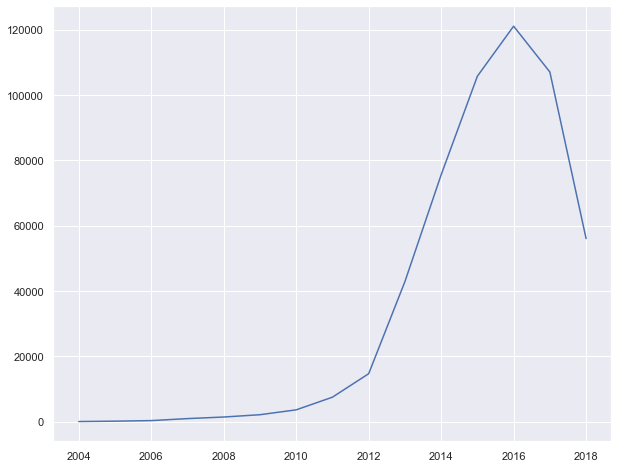

In [216]:
#Looking at number of reviews over the years - ANNOTATE
plt.figure(figsize=(10,8))
clean_review_df['year'].value_counts().sort_index().plot()
plt.show()

In [217]:
clean_review_df.groupby("year")["year"].value_counts()

year  year
2004  2004        34
2005  2005       145
2006  2006       321
2007  2007       931
2008  2008      1416
2009  2009      2122
2010  2010      3614
2011  2011      7492
2012  2012     14678
2013  2013     42876
2014  2014     75583
2015  2015    105766
2016  2016    121076
2017  2017    107053
2018  2018     56053
Name: year, dtype: int64

isolating to just 2016 and 2017 reviews

In [218]:
#filtering to 2016 and 2017 reviews
filtered_review_df = clean_review_df[((clean_review_df["year"] == 2016 )|(clean_review_df["year"] == 2017))].copy()
filtered_review_df.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,year,month
72,5.0,0.0,1,2017-12-30,A2BR01CI7K7GAN,B00004U9V2,mom and teacher,Bought for my daughter.,Has Good Reviews!,2017,12
73,5.0,0.0,1,2017-12-29,A1N6K3WYGUMHGO,B00004U9V2,Customer,Great cream for the skin.,Five Stars,2017,12


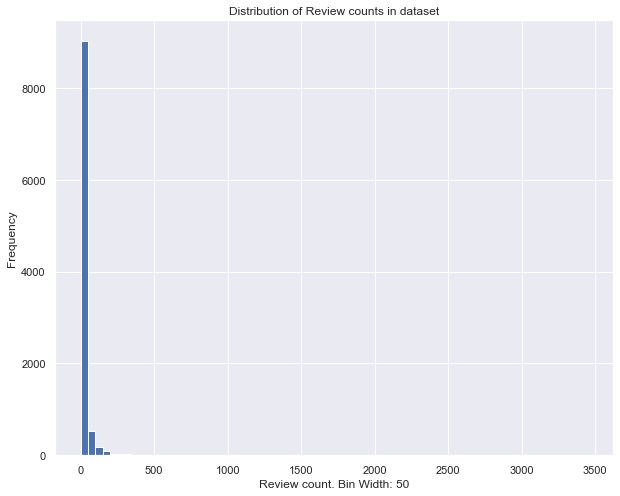

In [219]:
#histogram of reviews 
binwidth = 50

plt.figure(figsize=(10,8))
asin_data = filtered_review_df["asin"].value_counts()
plt.hist(asin_data , bins=np.arange(0,3500, binwidth))

plt.xlabel(f'Review count. Bin Width: {binwidth}')
plt.ylabel('Frequency')
plt.title('Distribution of Review counts in dataset')
plt.show()

In [220]:
#filtering to only those reviews that have more than 50 counts per product id 
filtered_review_df=filtered_review_df.groupby("asin").filter(lambda x:x['overall'].count() >=50)

In [221]:
filtered_review_df.shape

(140014, 11)

In [222]:
#creating pivot table 
year_pivot = pd.pivot_table(filtered_review_df, index="asin",columns = "year",values="overall" ,aggfunc=["count"]).reset_index()

#renaming columns
year_pivot.columns = ["asin", "year_2016", "year_2017"]

#adding in YoY pct change 
year_pivot["pct_change"] = (year_pivot["year_2017"] - year_pivot["year_2016"])/ year_pivot["year_2016"]*100

#total review count
year_pivot["total_reviews"] = (year_pivot["year_2017"] + year_pivot["year_2016"])

year_pivot

,asin,year_2016,year_2017,pct_change,total_reviews
0,B00004U9V2,149.0,149.0,0.000000,298.0
1,B00005V50B,100.0,67.0,-33.000000,167.0
2,B000066SYB,24.0,34.0,41.666667,58.0
3,B000068DWY,37.0,36.0,-2.702703,73.0
4,B00011QUKW,77.0,34.0,-55.844156,111.0
...,...,...,...,...,...
945,B01G4WNGGM,NaN,50.0,NaN,NaN
946,B01G4XAN3A,41.0,18.0,-56.097561,59.0
947,B01GDUM666,89.0,55.0,-38.202247,144.0
948,B01GFYWYC6,48.0,137.0,185.416667,185.0


In [223]:
#taking only counting reviews larger than 50 and pct_change higher than 1
asin_review_df = year_pivot[(year_pivot["pct_change"]>= 100) & (year_pivot["total_reviews"] >=50)]
asin_review_df

,asin,year_2016,year_2017,pct_change,total_reviews
6,B00014340I,86.0,206.0,139.534884,292.0
8,B0001435D4,68.0,142.0,108.823529,210.0
9,B00014GT8W,203.0,488.0,140.394089,691.0
14,B0001Z66UM,32.0,73.0,128.125000,105.0
51,B0007CXYN6,15.0,35.0,133.333333,50.0
...,...,...,...,...,...
936,B01DWRRV4A,8.0,46.0,475.000000,54.0
937,B01E7UY7AC,13.0,41.0,215.384615,54.0
944,B01FE6HMSM,7.0,55.0,685.714286,62.0
948,B01GFYWYC6,48.0,137.0,185.416667,185.0


In [224]:
#finding unique values of asin
asin_targets = list(asin_review_df["asin"].unique())

#new column 
filtered_review_df["trending_asin"] = filtered_review_df['asin'].isin(asin_targets)

In [225]:
filtered_review_df['trending_asin'] = np.where(filtered_review_df['trending_asin']== True, 1, 0)
filtered_review_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,year,month,trending_asin
72,5.0,0.0,1,2017-12-30,A2BR01CI7K7GAN,B00004U9V2,mom and teacher,Bought for my daughter.,Has Good Reviews!,2017,12,0
73,5.0,0.0,1,2017-12-29,A1N6K3WYGUMHGO,B00004U9V2,Customer,Great cream for the skin.,Five Stars,2017,12,0
74,1.0,0.0,0,2017-12-28,A3KPTMMK9D967W,B00004U9V2,fg59,"Maybe Im just not familiar with this brand, but if this is the type of fragrance they normally use...blech! It might be a good cream but I had to...",Bad fragrance,2017,12,0
75,5.0,0.0,1,2017-12-28,A3CEUD9051WKC0,B00004U9V2,candy973,This is one of my favorite creams. Highly recommend!!! Keeps hands moisturizers for a long time. Worth every penny.,Great product.,2017,12,0
76,5.0,0.0,1,2017-12-19,A69VISV3LE7DA,B00004U9V2,Candice,"I simply love this lotion! Originally, I received it as a gift. Have been buying it ever since!",Five Stars,2017,12,0


In [226]:
pct_trending = (filtered_review_df['trending_asin'].sum()/filtered_review_df.shape[0])*100
print(f"Trending products make up {round(pct_trending,2)}% of the dataset.") 

Trending products make up 11.09% of the dataset.


# Exploring the dataset 

In [227]:
filtered_review_df.groupby("reviewerID")["reviewerID"].value_counts().sort_values(ascending=False)

reviewerID      reviewerID    
A2OW1FKQFPIA5D  A2OW1FKQFPIA5D    29
AHN86VFJIJ2JP   AHN86VFJIJ2JP     28
AQY5XBYSENNZQ   AQY5XBYSENNZQ     28
A2YKWYC3WQJX5J  A2YKWYC3WQJX5J    27
A25QBCHO0KFT0P  A25QBCHO0KFT0P    24
                                  ..
A2CGUFPB2051QC  A2CGUFPB2051QC     1
A2CGRYPRUQLMPI  A2CGRYPRUQLMPI     1
A2CGPT17U7DI8H  A2CGPT17U7DI8H     1
A2CGOO388HODW4  A2CGOO388HODW4     1
AZZYUA6JI1MO0   AZZYUA6JI1MO0      1
Name: reviewerID, Length: 117496, dtype: int64

Reviewer ID is not super relevant to they predict if it's trending or not so we can remove both of these columns. 

In [228]:
columns = ['reviewerID','reviewerName']
for column in columns: 
     filtered_review_df = filtered_review_df.drop([column],axis=1)

#do we see any against trending_asin?

In [229]:
pivot = pd.pivot_table(filtered_review_df, index="month",columns = "trending_asin",values="overall" ,aggfunc=["count"]).reset_index()
pivot

month  count      
trending_asin            0     1
0                 1  11322  1126
1                 2  10281  1006
2                 3  11806  1331
3                 4  10568  1126
4                 5  10748  1232
5                 6  10418  1793
6                 7  11558  1516
7                 8  10363  1393
8                 9   9812  1216
9                10   9317  1181
10               11   8526  1142
11               12   9768  1465

# Feature engineering 

Feature engineering - adding new features to the datasets that may improve the result of the final model, for each dataset we can perform: 

Metadata
- category 
- top brands


Review
- adding relevance for upvotes? 
- One hot encoding

Metadata creation of categories

In [230]:
from collections import defaultdict
title_list = metadata_df_clean["title"].to_list()

temp = defaultdict(int)
 
# memorizing count
for title in title_list:
    for wrd in title.split():
        wrd = wrd.lower()
        
        clean_wrd = ""
        #searching through each letter and only accepting those in the alphabet
        for letter in wrd: 
            if letter >= 'a' and letter <= 'z': 
                clean_wrd = clean_wrd + letter
        temp[clean_wrd] += 1
 

In [231]:
#saving dictionaries for easy access for analyzing the titles
sorted_dict = sorted(temp.items(),key = lambda x:x[1], reverse = True)
sorted_dict_alpha = sorted(temp.items())

In [232]:
#output for csv 
df_dict = pd.DataFrame(sorted_dict_alpha)
df_dict.to_csv("myfile.csv",index=False)

In [293]:
#regex list for mapping out the different categories
regex_list = [r'\skin\B|moisturi[z|s](er|ing)|\bcleans.*(ing|r)\b|cellular|salve|essence|serum|maintenance|digestive|pevonia|micellar|kerr|filorga|complex|cleanse|osmosis|elixir|orlane|concentrate|manuka|stretch mark|cosmedix|clinical|redness|oralne|guinot|clarityrx|bioelements|reconstructor|liftosome|moisture|replenix|goldfaden|fender|mask|epicuren|\bface\b(?!\w*sur)|cell repair|facial|astringent|blinc|\bmasque\b|\bcreme\b|\btoner\b|acne|(?!hair spray)\b(face|facial) spray\b|mio|tired leg|butter|marini|badescu|elemis|youth|antiaging|makeup remover|e.r.3|tonic|body lotion|towelettes|occitane|\b(?<!sun )lotion\b|replenix cf|skincare|nuxe|ahava|crabtree|moisterizing|arden|jurlique|retinol|strivectin|\bremover\b|cream|bliss|\b(?<!hair )oil\b|scrub|acid|derm|skin|body|greyl|pureology|aloe|perricone|wipe|vichy|anti(?!per|oxid|friz)|caudalie|age|exfol|iredale|bisse|neova|squalane|ceut|neck|red flower|boscia|cellex-c|wrinkle|hyd*' #skincare
              ,r'hair|cond(i)tion|putty|eimi|dr.|klorane|mop|\b(moroccanoil|hard water|paste|inhibition|prevon|silken|teasing|frizz|cloud nine|davines|colorproof|marulaoil|abba|exquisiteoil|salon|chaz dean|milk_shake|oilhair|shampoo|shampooing|hairspray)\b|(?!face|facial)\b(hair|detangling|texture|volumizing) spray\b|protectant|treatment|styling|lipstick|brightening|brow(?!n)|paul mitchell|\b(?<!mist )spray\b|mousse|volumiz|hair oil|curl|texture|somme|wax|oribe|amika|text*|mist|volume|blandi|\bgel\b|rusk|sebastian|chi|rsquo|nioxin|furterer|folli|neuma|root|volumin|blonde(s)' #haircare 
              ,r'\w*(?<!s)nail|\bpolish\b(?!\w*ed|\w*er|\w*es|\w*ing\b)|heel|ridge|cuticle|dry drops|prostay|rgb|manicure|pedicure|crme|\bhand(s)?\b(?!bag)|\bopi\b|zoya|jessica|foot cream|gehwol fusskraft|cnd|coat|palisade|\b(?<!lip )lacquer\b' #nailcare
              ,r'soap(?!holder)|bath|shower(?!cap)|gianna rose|\bwash(?!mouth)|salt|rituals|molton brown|\bmud\b' #bath&shower
              ,r'shadow|beauty|\bli(ps)?\b(?!philip)|liner(?!clineral)|longo|son &amp;|lea journo|bb|mai|cargo|balm|makeup|lip lacquer|alloy|foundation|conceal-it|cosmetics|pencil|\bgloss\b|\bpalette\b|hormone|conceal(er)|\bprimer\b|corrector|mascara|rodial|\bmakeup\b(?! remover)|highlight(ing)|bronzing|bronzer|blush|powder|stila|cosmetic|lorac|\beye\b(?! makeup remover)|dermablend|jouer|highlighter|geller|tint|lash|bronze|contour|base|matte|berry|tonymoly|michelle phan|korres|lip|shadow(?!s)' #makeup
              ,r'eau|toilette|parfum|cologne|perfume|fragrance|rollerball|lolita|aroma|alora|pacifique|montale|alford|mancera|malandrino|woods|\bkenneth\b' #fragance
              ,r'\b(aftershave)|jack black|homme|men|him|man made|shaving|groom|anthony|shave|proglide|deodorant|pomade|razor|perspirant|billy|klein|beard|fusion proglide|baxter|shave|trimmer|shave(?!r)' #menscare
              ,r'tweezer|brush|showercap|capsule|clip(s)|philip|iron|plie|ddf|cotton|lightstim|purse pack|sponge|file|sharpener|nubrilliance|stephanie johnson|emi|potempa|japonesque|beachwaver|attachment|plate|t3|clarisonic|supplement|candle|papier|vitamin|\bdryer\b|sponge(s)|rollers|ceramic|mouth|tooth|teeth|diffuser|babyliss|\btea\b|comb|temptu|white|mirror|bag|curler|ghd|stand|supersmile|zwilling|ionic|tool(s)'#accessories 
              ,r'sun|spf|sunscreen|\btan\b|st. tropez|\btanning\b|\btanner\b|sun lotion' #suncare
              ,r'\bgift\b|\bset\b|kit|hamper|strop|\btravel\b|box' #other
             ]
                
column_names = ['c_skincare','c_haircare','c_nailandhands','c_bath&shower','c_makeup','c_fragance','c_menscare','c_accessories','c_suncare','c_other']


In [294]:
#for loop to create columns and then prints out the number of matches 
for column,regex_search in zip(column_names, regex_list):
    
    metadata_df_clean[column] = metadata_df_clean["title"].str.contains(
    regex_search
    , regex = True
    , case=False )
    counts = metadata_df_clean[column].sum()
    print(f"{column} column created with {counts} matches")

/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_12435/1037345614.py:4: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



c_skincare column created with 6549 matches


/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_12435/1037345614.py:4: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



c_haircare column created with 4775 matches


/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_12435/1037345614.py:4: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



c_nailandhands column created with 1044 matches
c_bath&shower column created with 784 matches


/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_12435/1037345614.py:4: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



c_makeup column created with 3266 matches
c_fragance column created with 1493 matches


/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_12435/1037345614.py:4: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



c_menscare column created with 1668 matches


/var/folders/k5/r4y7z25n2rz_yw3s46bn0m580000gn/T/ipykernel_12435/1037345614.py:4: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



c_accessories column created with 1979 matches
c_suncare column created with 594 matches
c_other column created with 799 matches


In [295]:
#creating new column for category
mapping_dict = { False: None
                , 'c_skincare': 'skincare'
                , 'c_haircare': 'haircare'
                , 'c_nailandhands': 'nails and hands'
                ,'c_bath&shower' : 'bath and shower'
                ,'c_makeup' : 'makeup'
                ,'c_fragance' : 'fragance'
                ,'c_accessories' : 'accessories'
                , 'c_menscare' : 'menscare'
                , 'c_other' : 'other'
                , 'c_suncare' : 'suncare'
               }

df_cat = metadata_df_clean.filter(like='c_')
metadata_df_clean['category'] = (df_cat.idxmax(axis=1).map(mapping_dict)
                    .where(df_cat.any(axis=1), mapping_dict[False]))

In [296]:
#sanity check 
metadata_null = metadata_df_clean[metadata_df_clean['category']=='none']
metadata_null.shape

(0, 20)

In [297]:
#remove the c columns
column_names = ['c_skincare','c_haircare','c_nailandhands','c_bath&shower','c_makeup','c_fragance','c_menscare','c_accessories','c_suncare','c_other']

for column in column_names: 
    metadata_df_clean= metadata_df_clean.drop(column, axis=1)

In [299]:
metadata_df_clean.isna().sum()

title                     0
asin                      0
price_USD              5138
ranking                   0
product_description       0
also_buy_counts           0
also_view_counts          0
category                 10
brand                     0
main_brands               0
dtype: int64

### Top brands

In [300]:
# the second replace just removes repeated whitespaces .str.replace(r"\s+", " ")
metadata_df_clean["title"] = metadata_df_clean["title"].str.replace(r"[^a-zA-Z]", " ", regex=True)
metadata_df_clean["title"] = metadata_df_clean["title"].str.strip()
metadata_df_clean.head(2)

,title,asin,price_USD,ranking,product_description,also_buy_counts,also_view_counts,category,brand,main_brands
0,Crabtree amp Evelyn Gardener s Ultra Moisturising Hand Therapy Pump g OZ,B00004U9V2,30.0,4324,"After a long day of handling thorny situations, our new hand therapy pump is just the help you need. It contains shea butter as well as extracts o...",56.0,48.0,skincare,Crabtree,The Art of Shaving
1,AHAVA Bath Salts,B0000531EN,NaN,1633549,"If you haven't experienced the pleasures of bathing in the Dead Sea, Bath Crystals are the next best thing. Rich in health-inducing minerals inclu...",0.0,0.0,skincare,AHAVA,AHAVA


In [301]:
#creating brand column
metadata_df_clean["brand"] = metadata_df_clean["title"].apply(lambda x: x.split(" ",1)[0])
metadata_df_clean.head(2)

,title,asin,price_USD,ranking,product_description,also_buy_counts,also_view_counts,category,brand,main_brands
0,Crabtree amp Evelyn Gardener s Ultra Moisturising Hand Therapy Pump g OZ,B00004U9V2,30.0,4324,"After a long day of handling thorny situations, our new hand therapy pump is just the help you need. It contains shea butter as well as extracts o...",56.0,48.0,skincare,Crabtree,The Art of Shaving
1,AHAVA Bath Salts,B0000531EN,NaN,1633549,"If you haven't experienced the pleasures of bathing in the Dead Sea, Bath Crystals are the next best thing. Rich in health-inducing minerals inclu...",0.0,0.0,skincare,AHAVA,AHAVA


In [ ]:
df_combined["brand"].nunique()

There are over 200 unique values let's isolate these to the top 50. 

In [302]:
#finding most frequently occuring words in string. Ref: https://www.includehelp.com/python/counting-the-frequency-of-words-in-a-pandas-dataframe.aspx
pd.set_option('display.max_rows', 50)
res = metadata_df_clean["brand"].value_counts()
res.head(50)

L              406
Crabtree       184
AHAVA          176
stila          165
bliss          159
Mario          145
butter         141
Julep          129
JAPONESQUE     124
Rituals        122
Paul           120
Glo            119
ELEMIS         114
OPI            113
Archipelago    109
LORAC          105
Elizabeth      104
Borghese       103
CND            102
RUSK           102
The             97
CHI             97
jane            94
BURBERRY        91
Davines         90
Pureology       90
Rodial          84
theBalm         81
Eau             78
VINCENT         78
Juice           77
Osmosis         75
Red             72
Laura           72
NUXE            72
Anthony         70
LAFCO           70
Vichy           70
La              70
P               68
Calvin          67
Zoya            65
BaBylissPRO     62
Bioelements     62
StriVectin      61
ORIBE           61
PCA             60
Mustela         60
Rene            58
Natura          56
Name: brand, dtype: int64

Now that we've added in trending we can combine the datasets 

In [1]:
# mapping str.contains using a class: https://stackoverflow.com/questions/48590488/map-str-contains-across-pandas-dataframe

class dict_partial(dict):
    def __getitem__(self, value):
        for k in self.keys():
            if k in value:
                return self.get(k)
        else:
            return self.get(None)
    

brand_map = dict_partial({'Crabtree':'Crabtree & Evelyn', 
                            'AHAVA' :'AHAVA',
                            'stila':'Stila',
                            'LORAC':'LORAC',
                            'JAPONESQUE':'Japonesque',
                            'CND':'CND',
                            "L Occitane":"L'occitane ", 
                            'bliss' :'Bliss',
                            'BURBERRY':'Burberry',
                            'CHI':'CHI',
                            'Mario Badescu':'Mario Badescu',
                            'butter':'Butter London',
                            "Julep":"Julep", 
                            'bliss' :'Bliss',
                            'Ritual':'Rituals',
                            'Rituals Foaming':'Rituals',
                            'Paul':'Paul Mitchell',
                            'GloMinerals' : 'GloMinerals',
                            'Glo Skin':'Glo Skin',
                            'ELEMIS':'Elemis',
                            'OPI':'OPI',
                            'Archipelago':'Archipelago',
                            'Elizabeth':'Elizabeth Arden',
                            'Borghese' : 'Borghese',

                            'Glo Skin':'Glo Skin',
                            'jane':'Jane Iredale',
                            'The Art':'The Art of Shaving',
                            'RUSK':'RUSK',
                            'Davines':'Davines',
                            'Pureology':'Pureology', 
                            'Rodial' :'Rodial',
                            'theBalm':'theBalm',
                            'VINCENT':'Vincent Longo',
                            'Osmosis':'Osmosis',
                            "Red":"Red Flower", 
                            "Laura Biagiotti": "Laura Biagiotti",
                            'Laura Geller':'Laura Geller',
                            'NUXE':'NUXE',
                            'Anthony Logistics':'Anthony Logistics',
                            'LAFCO':'LAFCO',
                            "Vichy":"Vichy",
                            'Lacoste':'Lacoste',
                            'Osmosis':'Osmosis',
                            "La Roche Posay" : "La Roche Posay",
                            'Lacoste':'Lacoste',
                            'Calvin':'Calvin Klein',
                            'Zoya':'Zoya',
                            'BaBylissPRO':'BaBylissPro',
                            "Bioelements":"Bioelements", 
                            "StriVectin": "StriVectin",
                            'ORIBE':'Oribe',
                            'PCA':'PCA Skin',
                            "Mustela":"Mustela", 
                            "Hydra Bebe":"Mustela",
                            "Rene": "Rene Furterer",
                            'Natura':'Natura Bisse',
                            'TS':'TS',
                            "Soy":"Soy"
                            })
metadata_df_clean['main_brands'] = metadata_df_clean['title'].apply(lambda x: brand_map[x])

metadata_df_clean['main_brands'] = metadata_df_clean['main_brands'].fillna("Other")


NameError: name 'metadata_df_clean' is not defined

In [328]:
#explore trending products with brand? graph

In [329]:
metadata_df_clean.isna().sum()

title                     0
asin                      0
price_USD              5138
ranking                   0
product_description       0
also_buy_counts           0
also_view_counts          0
category                 10
brand                     0
main_brands               0
dtype: int64

In [330]:
pd.set_option('display.max_colwidth', 150)
df_combined = pd.merge(filtered_review_df,metadata_df_clean, how="left", on=["asin", "asin"])

In [331]:
#taking median price for price_usd to map null values to 
price_per_brand = df_combined.groupby("main_brands")["price_USD"].median()


In [332]:
# overwrite the missing price values with median price where possible
df_combined["price_USD"] = np.where(df_combined["price_USD"].isna(), df_combined["main_brands"].map(price_per_brand), df_combined["price_USD"])

In [347]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140014 entries, 0 to 140013
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   overall              140014 non-null  float16       
 1   vote                 140014 non-null  float32       
 2   verified             140014 non-null  int32         
 3   reviewTime           140014 non-null  datetime64[ns]
 4   asin                 140014 non-null  object        
 5   reviewText           140014 non-null  object        
 6   summary              140014 non-null  object        
 7   year                 140014 non-null  int32         
 8   month                140014 non-null  int32         
 9   trending_asin        140014 non-null  int64         
 10  title                139605 non-null  object        
 11  price_USD            139348 non-null  float64       
 12  ranking              139605 non-null  float64       
 13  product_descri

In [335]:
df_combined_null = df_combined[df_combined["price_USD"].isna()]
df_combined_null.groupby('main_brands')['title'].unique()

main_brands
Borghese    [Borghese Superiore State of the Art Mascara, Borghese Fango Active Mud Mask for Face and Body       oz]
Rituals                                                          [Rituals Foaming Shower Gel  Yogi Flow      fl  oz]
Name: title, dtype: object

In [352]:
remaining_map = dict_partial( {"Fango": 23.00, 
                            "Superiore" : 50.00,
                            "Rituals Foaming": 15.00
                            })
df_combined["price_USD"] = np.where(df_combined["price_USD"].isna(), df_combined["title"].map(remaining_map), df_combined["price_USD"])

In [360]:
df_combined[df_combined["price_USD"].isna()]

,overall,vote,verified,reviewTime,asin,reviewText,summary,year,month,trending_asin,title,price_USD,ranking,product_description,also_buy_counts,also_view_counts,category,brand,main_brands
14826,5.0,0.0,1,2017-11-21,B000A618E6,"comfortable application , full unclumped lashes",Five Stars,2017,11,0,Borghese Superiore State of the Art Mascara,NaN,622270.0,"Looking for lashes that go to great lengths? We found the perfect brush that lifts and separates, coats and curls. We combined it with the perfect...",0.0,0.0,makeup,Borghese,Borghese
14827,3.0,0.0,1,2017-12-11,B000A618E6,I used it and didn't like how when my eyes water it takes forever to dry and it smeared easily. I gave it to my daughter because she has longer e...,Not my favorite,2017,12,0,Borghese Superiore State of the Art Mascara,NaN,622270.0,"Looking for lashes that go to great lengths? We found the perfect brush that lifts and separates, coats and curls. We combined it with the perfect...",0.0,0.0,makeup,Borghese,Borghese
14828,5.0,2.0,1,2017-05-11,B000A618E6,"I prefer this mascara over other brands. It has a gel formula, which I like. It goes on easily and doesn't look ""cakey"" on my lashes. Other bra...","which I like. It goes on easily and doesn't look ""cakey"" ...",2017,5,0,Borghese Superiore State of the Art Mascara,NaN,622270.0,"Looking for lashes that go to great lengths? We found the perfect brush that lifts and separates, coats and curls. We combined it with the perfect...",0.0,0.0,makeup,Borghese,Borghese
14829,5.0,0.0,1,2017-04-11,B000A618E6,Love this mascara!,Five Stars,2017,4,0,Borghese Superiore State of the Art Mascara,NaN,622270.0,"Looking for lashes that go to great lengths? We found the perfect brush that lifts and separates, coats and curls. We combined it with the perfect...",0.0,0.0,makeup,Borghese,Borghese
14830,1.0,0.0,1,2017-10-28,B000A618E6,The mascara box looked old/used and the mascara was dry. Did not seem like new mascara.,Sub-par,2017,10,0,Borghese Superiore State of the Art Mascara,NaN,622270.0,"Looking for lashes that go to great lengths? We found the perfect brush that lifts and separates, coats and curls. We combined it with the perfect...",0.0,0.0,makeup,Borghese,Borghese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139353,5.0,0.0,1,2017-12-17,B001B1SKRM,good,Five Stars,2017,12,0,Borghese Fango Active Mud Mask for Face and Body oz,NaN,402126.0,"Our signature and classic Fango Active is a one-and-only, must-have, mineral-rich mud. It's a sensational step beyond everyday clean. Derived from...",0.0,0.0,skincare,Borghese,Borghese
139354,5.0,0.0,1,2017-04-12,B001B1SKRM,very good,Five Stars,2017,4,0,Borghese Fango Active Mud Mask for Face and Body oz,NaN,402126.0,"Our signature and classic Fango Active is a one-and-only, must-have, mineral-rich mud. It's a sensational step beyond everyday clean. Derived from...",0.0,0.0,skincare,Borghese,Borghese
139355,5.0,0.0,1,2017-10-28,B001B1SKRM,"I was so happy to re discover this product, I used it years ago and loved it then and still love it now! I will definitely purchase it again!","Loved it then, love it now!",2017,10,0,Borghese Fango Active Mud Mask for Face and Body oz,NaN,402126.0,"Our signature and classic Fango Active is a one-and-only, must-have, mineral-rich mud. It's a sensational step beyond everyday clean. Derived from...",0.0,0.0,skincare,Borghese,Borghese
139356,5.0,0.0,1,2017-10-10,B001B1SKRM,have loved this mud mask for years. So so nice to use it again! :),Five Stars,2017,10,0,Borghese Fango Active Mud Mask for Face and Body oz,NaN,402126.0,"Our signature and classic Fango Active is a one-and-only, must-have, mineral-rich mud. It's a sensational step beyond everyday clean. Derived from...",0.0,0.0,skincare,Borghese,Borghese


In [354]:
df_combined_null = df_combined[df_combined["price_USD"].isna()]

In [361]:
#remaining nulls are low we can drop these
df_combined =df_combined.dropna()

In [362]:
df_combined.isna().sum().sum()

0

In [371]:
columns = ['brand']
for column in columns: 
     df_combined = df_combined.drop([column],axis=1)

KeyError: "['brand'] not found in axis"

In [363]:
#saving to csv 
import os  
os.makedirs('/Users/mac/Desktop/Data/CAPSTONE', exist_ok=True)  
df_combined.to_csv('clean/clean_data.csv') 

In [369]:
df_combined.shape

(139188, 17)

In [370]:
df_combined

,overall,vote,verified,reviewTime,asin,reviewText,summary,year,month,trending_asin,price_USD,ranking,product_description,also_buy_counts,also_view_counts,category,main_brands
0,5.0,0.0,1,2017-12-30,B00004U9V2,Bought for my daughter.,Has Good Reviews!,2017,12,0,30.00,4324.0,"After a long day of handling thorny situations, our new hand therapy pump is just the help you need. It contains shea butter as well as extracts o...",56.0,48.0,skincare,The Art of Shaving
1,5.0,0.0,1,2017-12-29,B00004U9V2,Great cream for the skin.,Five Stars,2017,12,0,30.00,4324.0,"After a long day of handling thorny situations, our new hand therapy pump is just the help you need. It contains shea butter as well as extracts o...",56.0,48.0,skincare,The Art of Shaving
2,1.0,0.0,0,2017-12-28,B00004U9V2,"Maybe Im just not familiar with this brand, but if this is the type of fragrance they normally use...blech! It might be a good cream but I had to...",Bad fragrance,2017,12,0,30.00,4324.0,"After a long day of handling thorny situations, our new hand therapy pump is just the help you need. It contains shea butter as well as extracts o...",56.0,48.0,skincare,The Art of Shaving
3,5.0,0.0,1,2017-12-28,B00004U9V2,This is one of my favorite creams. Highly recommend!!! Keeps hands moisturizers for a long time. Worth every penny.,Great product.,2017,12,0,30.00,4324.0,"After a long day of handling thorny situations, our new hand therapy pump is just the help you need. It contains shea butter as well as extracts o...",56.0,48.0,skincare,The Art of Shaving
4,5.0,0.0,1,2017-12-19,B00004U9V2,"I simply love this lotion! Originally, I received it as a gift. Have been buying it ever since!",Five Stars,2017,12,0,30.00,4324.0,"After a long day of handling thorny situations, our new hand therapy pump is just the help you need. It contains shea butter as well as extracts o...",56.0,48.0,skincare,The Art of Shaving
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140009,2.0,0.0,1,2017-06-04,B01D0KHXGK,Meh! Flat iron works better,Disappointing results!,2017,6,0,21.29,171884.0,"Thermally activated smoothing treatment combines with the heat of a styling iron to smooth the hair cuticle, lock in moisture and seal out humidit...",0.0,0.0,skincare,TS
140010,1.0,0.0,1,2017-12-03,B01D0KHXGK,It doesn't grip the hair - I'm very disappointed.,One Star,2017,12,0,21.29,171884.0,"Thermally activated smoothing treatment combines with the heat of a styling iron to smooth the hair cuticle, lock in moisture and seal out humidit...",0.0,0.0,skincare,TS
140011,4.0,0.0,1,2017-02-22,B01D0KHXGK,Really works! I have curly hair and you can get the best results if you brush out your hair before letting this straighten out your hair. The long...,It works(:,2017,2,0,21.29,171884.0,"Thermally activated smoothing treatment combines with the heat of a styling iron to smooth the hair cuticle, lock in moisture and seal out humidit...",0.0,0.0,skincare,TS
140012,1.0,0.0,1,2017-02-17,B01D0KHXGK,DIDNT STRAIGHTEN HAIR,One Star,2017,2,0,21.29,171884.0,"Thermally activated smoothing treatment combines with the heat of a styling iron to smooth the hair cuticle, lock in moisture and seal out humidit...",0.0,0.0,skincare,TS


#Add correlation table 
#try to fix mapping 